### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
!pip install git+https://github.com/jfilter/split-folders.git


  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-6rscp2zl
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-6rscp2zl
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for split_folders: filename=split_folders-0.5.1-py3-none-any.whl size=8400 sha256=2f6facb60a29342f59af07a8d7abf1e3448e214ffca4bdd07c17de34c1bb2d18
  Stored in directory: /tmp/pip-ephem-wheel-cache-vk357y29/wheels/0c/da/06/fcebe493adfe604ee9a1d4511e3932a6e63a044edb7a10dec8
Successfully built split_folders


In [ ]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = '/content/drive/MyDrive/Dataset (1)'

# Set the base directory for the split images
output_folder = '/content/drive/MyDrive/Split'

# Set the ratio of images for each split
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


Copying files: 6410 files [05:48, 18.37 files/s]
Copying files: 6410 files [02:37, 40.69 files/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )

validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = '/content/drive/MyDrive/Split/train'
validation_dir = '/content/drive/MyDrive/Split/val'
test_dir = '/content/drive/MyDrive/Split/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 10

Found 3845 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.
Found 1284 images belonging to 4 classes.


In [ ]:
# class_names = train_generator.class_names
# class_names

class_names = list(train_generator.class_indices.keys())
class_names



['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

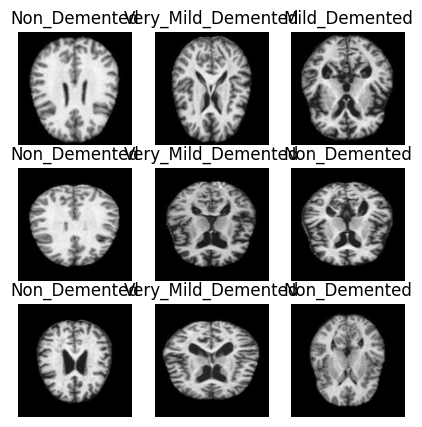

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


## Data Augmentation

In [ ]:
#preprocessing for rotation and zoom
def data_augmentar():

    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))

    return data_augmentation

In [ ]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

## Solving Imbalanced Data Problem

In [ ]:
## Calculate number of samples in each class.
input_folder = '/content/drive/MyDrive/Dataset (1)'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3210,
 'Very_Mild_Demented': 2240}

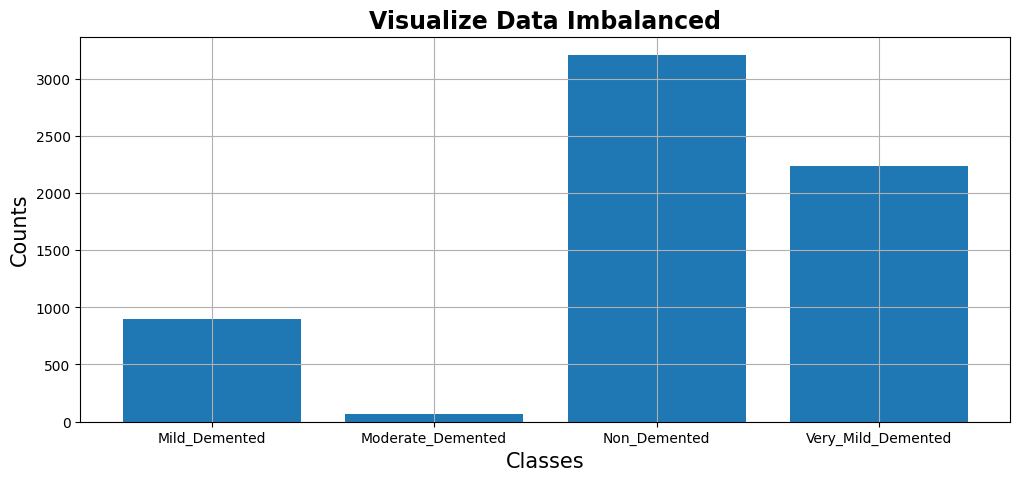

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [ ]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.04
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.72


In [ ]:
models=[]
acc=[]

### **VGG19**

In [ ]:
base_model_3 = VGG19(input_shape=(128,128,3),
                         include_top=False,
                         weights="imagenet")
for layer in base_model_3.layers:
  layer.trainable= False

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model3 = tf.keras.Sequential([base_model_3, global_average_layer,
  keras.layers.BatchNormalization(),
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])


In [ ]:

model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model3.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)

Epoch 1/10
61/61 [==============================] - 53s 615ms/step - loss: 0.9663 - accuracy: 0.5306 - auc: 0.8227 - precision: 0.6153 - recall: 0.3969 - val_loss: 1.1129 - val_accuracy: 0.5652 - val_auc: 0.8357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
61/61 [==============================] - 37s 602ms/step - loss: 0.8647 - accuracy: 0.5896 - auc: 0.8593 - precision: 0.6782 - recall: 0.4484 - val_loss: 1.0773 - val_accuracy: 0.5777 - val_auc: 0.8437 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
61/61 [==============================] - 36s 595ms/step - loss: 0.7940 - accuracy: 0.6356 - auc: 0.8825 - precision: 0.7092 - recall: 0.5113 - val_loss: 0.9393 - val_accuracy: 0.6245 - val_auc: 0.8674 - val_precision: 0.8863 - val_recall: 0.2069
Epoch 4/10
61/61 [==============================] - 36s 595ms/step - loss: 0.7463 - accuracy: 0.6666 - auc: 0.8969 - precision: 0.7170 - recall: 0.5813 - val_loss: 0.9086 - val_accuracy: 0.6682 - val_auc: 0.8841 -

In [ ]:
models.append("VGG 19")
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
result = model3.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

train_generator

61/61 [==============================] - 33s 539ms/step - loss: 0.4576 - accuracy: 0.8270 - auc: 0.9678 - precision: 0.8640 - recall: 0.7779
Train Loss = 0.45762449502944946
Train Accuracy = 0.827048122882843
Train AUC = 0.9677838683128357
Train Precision = 0.8639514446258545
Train Recall = 0.7778933644294739


In [ ]:
filepath = './Vgg_best_weights.hdf5'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
history3=model3.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 40,callbacks = callback_list,
                        verbose = 1,batch_size=32)

Epoch 1/40
1/1 [==============================] - ETA: 0s - loss: 0.3616 - accuracy: 0.8281 - auc: 0.9799 - precision: 0.8689 - recall: 0.8281
Epoch 1: val_accuracy improved from -inf to 0.76581, saving model to ./Vgg_best_weights.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.3616 - accuracy: 0.8281 - auc: 0.9799 - precision: 0.8689 - recall: 0.8281 - val_loss: 0.5595 - val_accuracy: 0.7658 - val_auc: 0.9438 - val_precision: 0.7852 - val_recall: 0.7307
Epoch 2/40
1/1 [==============================] - ETA: 0s - loss: 0.4174 - accuracy: 0.8281 - auc: 0.9711 - precision: 0.8909 - recall: 0.7656
Epoch 2: val_accuracy improved from 0.76581 to 0.77127, saving model to ./Vgg_best_weights.hdf5
1/1 [==============================] - 11s 11s/step - loss: 0.4174 - accuracy: 0.8281 - auc: 0.9711 - precision: 0.8909 - recall: 0.7656 - val_loss: 0.5400 - val_accuracy: 0.7713 - val_auc: 0.9474 - val_precision: 0.7939 - val_recall: 0.7369
Epoch 3/40
1/1 [=========================

In [ ]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)



21/21 [==============================] - 6s 277ms/step - loss: 0.5566 - accuracy: 0.7726 - auc: 0.9479 - precision: 0.7935 - recall: 0.7601
Test Loss = 0.5565821528434753
Test Accuracy = 0.7725856900215149
Test AUC = 0.9478912353515625
Test Precision = 0.7934959530830383
Test Recall = 0.7601246237754822


1/1 [==============================] - 0s 20ms/step
98.97 % chances are there that the image is Mild_Demented


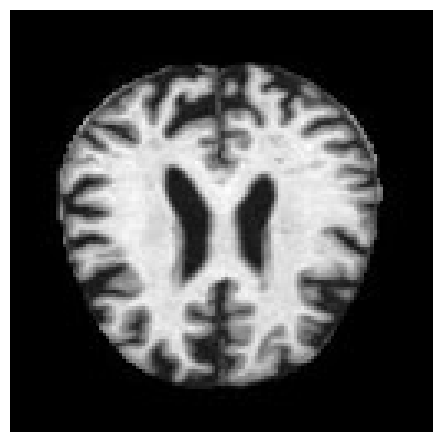

In [ ]:

dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Dataset (1)/Mild_Demented/mild_103.jpg', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model3.predict(img),axis=1)
y_pred_prob = model3.predict(img)
y_pred = np.round(np.max(y_pred_prob)*100,2)

print(y_pred, '% chances are there that the image is',idc[answer[0]])

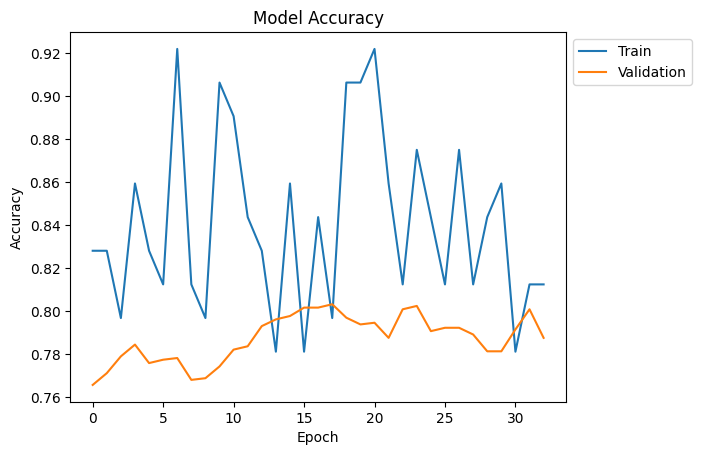

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# plt.plot(history3.history['auc_1'])
# plt.plot(history3.history['val_auc_1'])
# plt.title('Model AUC')
# plt.ylabel('AUC')
# # plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
# plt.show()

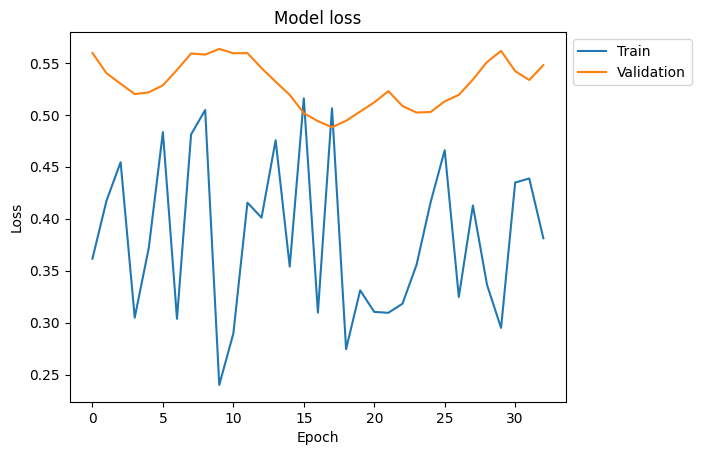

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

21/21 [==============================] - 5s 216ms/step


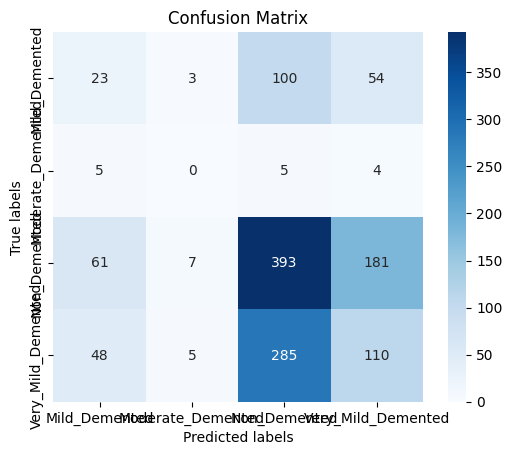

In [ ]:
#Confusion Matrix for vgg19

p = model3.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab = test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)


## DenseNet121

In [ ]:
base_model_4 = DenseNet121(input_shape=(128,128,3),
                         include_top=False,
                         weights="imagenet")

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model_4.layers:
    layer.trainable=False

In [ ]:

model=Sequential()
model.add(base_model_4)

model.add(Dropout(0.5))
model.add(Flatten()
)
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))

model.add(Dense(4,activation='softmax'))

In [ ]:
models.append(model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization_1 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 2048)              33556480  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                     

In [ ]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)


Epoch 1/10
61/61 [==============================] - 65s 879ms/step - loss: 1.9753 - accuracy: 0.4700 - auc_1: 0.7550 - precision_1: 0.4772 - recall_1: 0.4536 - val_loss: 3.2317 - val_accuracy: 0.5394 - val_auc_1: 0.7619 - val_precision_1: 0.5406 - val_recall_1: 0.5355
Epoch 2/10
61/61 [==============================] - 36s 583ms/step - loss: 1.3782 - accuracy: 0.5282 - auc_1: 0.7997 - precision_1: 0.5417 - recall_1: 0.4965 - val_loss: 2.3407 - val_accuracy: 0.5168 - val_auc_1: 0.7883 - val_precision_1: 0.5213 - val_recall_1: 0.5066
Epoch 3/10
61/61 [==============================] - 43s 691ms/step - loss: 1.1158 - accuracy: 0.5810 - auc_1: 0.8374 - precision_1: 0.5974 - recall_1: 0.5384 - val_loss: 1.0799 - val_accuracy: 0.5855 - val_auc_1: 0.8469 - val_precision_1: 0.6165 - val_recall_1: 0.5308
Epoch 4/10
61/61 [==============================] - 37s 603ms/step - loss: 0.9822 - accuracy: 0.5927 - auc_1: 0.8539 - precision_1: 0.6178 - recall_1: 0.5511 - val_loss: 0.8954 - val_accuracy: 

In [ ]:
models.append("DenseNet121")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 4, 4, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization_1 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 2048)              33556480  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                     

In [ ]:
result = model.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

61/61 [==============================] - 33s 538ms/step - loss: 0.5035 - accuracy: 0.8057 - auc_1: 0.9597 - precision_1: 0.8495 - recall_1: 0.7342
Train Loss = 0.5034729242324829
Train Accuracy = 0.8057217001914978
Train AUC = 0.9596602320671082
Train Precision = 0.8495335578918457
Train Recall = 0.7342002391815186


In [ ]:
filepath = './DenseNet121_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'auto' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_accuracy',
                                mode='auto',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
history4 = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.8170 - accuracy: 0.6719 - auc_1: 0.8856 - precision_1: 0.7273 - recall_1: 0.6250
Epoch 1: val_accuracy improved from -inf to 0.73536, saving model to ./DenseNet121_best_weights.hdf5
1/1 [==============================] - 10s 10s/step - loss: 0.8170 - accuracy: 0.6719 - auc_1: 0.8856 - precision_1: 0.7273 - recall_1: 0.6250 - val_loss: 0.5822 - val_accuracy: 0.7354 - val_auc_1: 0.9375 - val_precision_1: 0.7795 - val_recall_1: 0.6651
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.7344 - auc_1: 0.9262 - precision_1: 0.7586 - recall_1: 0.6875
Epoch 2: val_accuracy improved from 0.73536 to 0.73770, saving model to ./DenseNet121_best_weights.hdf5
1/1 [==============================] - 8s 8s/step - loss: 0.6309 - accuracy: 0.7344 - auc_1: 0.9262 - precision_1: 0.7586 - recall_1: 0.6875 - val_loss: 0.5845 - val_accuracy: 0.7377 - val_auc_1: 0.9370 - val_precision_1: 0.7790 - val_recall_1

In [ ]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

21/21 [==============================] - 5s 231ms/step - loss: 0.5566 - accuracy: 0.7726 - auc: 0.9479 - precision: 0.7935 - recall: 0.7601
Test Loss = 0.5565822720527649
Test Accuracy = 0.7725856900215149
Test AUC = 0.9478912353515625
Test Precision = 0.7934959530830383
Test Recall = 0.7601246237754822


1/1 [==============================] - 0s 31ms/step
40.33 % chances are there that the image is Moderate_Demented


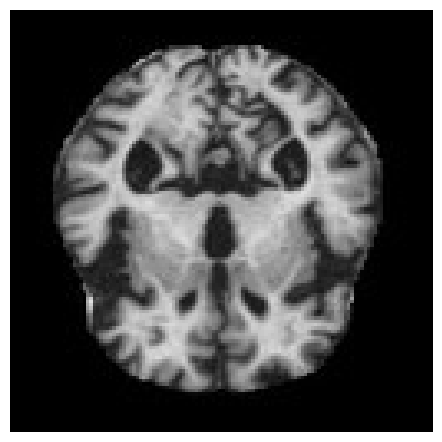

In [ ]:
dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Dataset (1)/Moderate_Demented/moderate_15.jpg', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img),axis=1)
y_pred_prob = model.predict(img)
y_pred = np.round(np.max(y_pred_prob)*100,2)

print(y_pred, '% chances are there that the image is',idc[answer[0]])

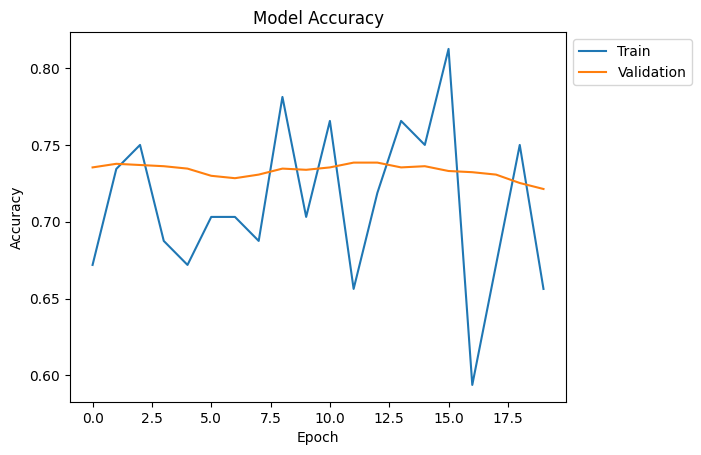

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# plt.plot(history4.history['auc'])
# plt.plot(history4.history['val_auc'])
# plt.title('Model AUC')
# plt.ylabel('AUC')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
# plt.show()

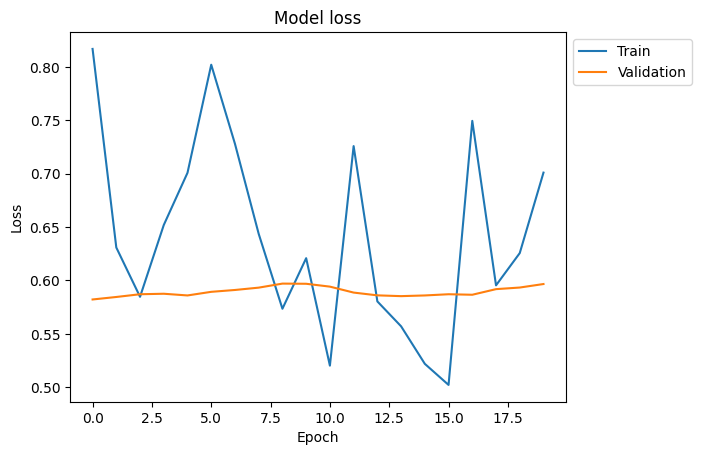

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

21/21 [==============================] - 13s 496ms/step


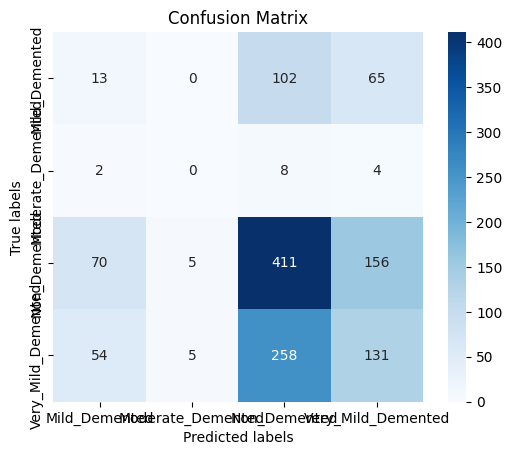

In [ ]:
#Confusion Matrix for densenet121

p = model.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab =test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)


In [ ]:
model3.save('model.h5')


In [ ]:
model.save('model1.h5')